# 0_loader

In [16]:
import torch
from torchvision.datasets import MNIST, FashionMNIST, CelebA
import medmnist
from medmnist import ChestMNIST, PneumoniaMNIST
from torchvision import transforms
from _utils.load_utils import display_from_batch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# params: batch_size
batch_size = 256

train = FashionMNIST("./_data", train=True, download=True, transform=transforms.ToTensor())
test = FashionMNIST("./_data", train=False, download=True, transform=transforms.ToTensor())
classnames = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}
# train = PneumoniaMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = PneumoniaMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={0: 'normal', 1: 'pneumonia'}

# train = ChestMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = ChestMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={
#     '0': 'atelectasis', 
#     '1': 'cardiomegaly', 
#     '2': 'effusion', 
#     '3': 'infiltration', 
#     '4': 'mass', 
#     '5': 'nodule', 
#     '6': 'pneumonia', 
#     '7': 'pneumothorax', 
#     '8': 'consolidation', 
#     '9': 'edema', 
#     '10': 'emphysema', 
#     '11': 'fibrosis', 
#     '12': 'pleural', 
#     '13': 'hernia'
# }


# train = CelebA(root='./_data', split='train', transform=transforms.Compose([transforms.ToTensor()]), download=True)
# test = CelebA(root='./_data', split='test', transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# return train_loader, test_loader

In [17]:
print(train)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./_data
    Split: Train
    StandardTransform
Transform: ToTensor()


# _utils

In [18]:
train_iter = iter(train_loader)

tensor([6, 5, 6, 8])


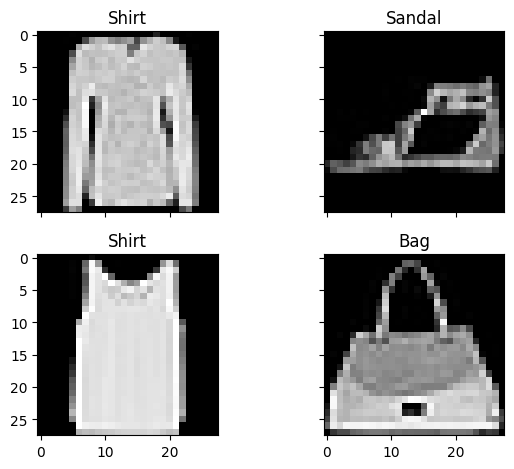

In [19]:
train_batch = next(train_iter)
# params: batch, classname, nrows, ncols
print(train_batch[1][:4])
# print(train_batch[1].squeeze(1))
# print(train_batch[1].squeeze(1).to(torch.long))
# print(train_batch[1].squeeze(1).to(torch.long).dtype)
display_from_batch(train_batch, 2, 2, classnames)

# return none

# 1_model

In [20]:
import torch
from torch import nn, optim

class MyCNN(nn.Module):
    def __init__(self, height, width, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        self.act1 = nn.ReLU()
        h = (height - 4)
        w = (width - 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.act2 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool2 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.act3 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool3 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        # 3x3 이미지가 됨
        self.fc4 = nn.Linear(64 * int(h) * int(w), 100)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(100, out_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        # 모듈화 필요>>>
        sizes = x.size()
        x = x.view(sizes[0], -1)
        # <<<모듈화 필요
        
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        return x


In [22]:
model = MyCNN(height=28, width=28, out_features=10)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
print('MyCNN: ', sum(numel_list), numel_list)
from torchinfo import summary
summary(model, input_size=(1,1,28,28), device='cpu') 

MyCNN:  123222 [400, 16, 12800, 32, 51200, 64, 57600, 100, 1000, 10]


Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           416
├─ReLU: 1-2                              [1, 16, 24, 24]           --
├─Conv2d: 1-3                            [1, 32, 20, 20]           12,832
├─ReLU: 1-4                              [1, 32, 20, 20]           --
├─MaxPool2d: 1-5                         [1, 32, 10, 10]           --
├─Conv2d: 1-6                            [1, 64, 6, 6]             51,264
├─ReLU: 1-7                              [1, 64, 6, 6]             --
├─MaxPool2d: 1-8                         [1, 64, 3, 3]             --
├─Linear: 1-9                            [1, 100]                  57,700
├─ReLU: 1-10                             [1, 100]                  --
├─Linear: 1-11                           [1, 10]                   1,010
Total params: 123,222
Trainable params: 123,222
Non-trainable params:

# 2_train

In [23]:
import torch
from torch import nn, optim
import collections
import tqdm
all_acc_dict = collections.OrderedDict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import datetime
current_time = datetime.datetime.today() # 2021-08-15 20:58:43.302125
current_time = current_time.strftime('%Y%m%d%H%M%S') # 20210815205827

In [24]:
def eval_net(model, data_loader, device="cpu"):
    model.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        # y = y.squeeze(1).to(torch.long).to(device)
        with torch.no_grad():
            _, y_pred = model(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [25]:
n_epochs = 100

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_losses = []
train_acc = []
val_acc = []
for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    n = 0
    n_acc = 0
    # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        xx = xx.to(device)
        yy = yy.to(device)
        # yy = yy.squeeze(1).to(torch.long).to(device)
        h = model(xx)
        loss = loss_fn(h, yy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += len(xx)
        _, y_pred = h.max(1)
        n_acc += (yy == y_pred).float().sum().item()
    train_losses.append(running_loss / i)
    # 훈련 데이터의 예측 정확도
    train_acc.append(n_acc / n)

    # 검증 데이터의 예측 정확도
    val_acc.append(eval_net(model, test_loader, device))
    print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
print('-----------training finished-----------')
print('train_losses: ', train_losses)
print('train_acc: ', train_acc)
print('val_acc: ', val_acc)

 72%|█████████████████████████████▌           | 169/234 [00:04<00:01, 39.44it/s]

KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_acc)
plt.plot(val_acc)